In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np


hourly = pd.read_csv('hourlyUPRO14-24.csv')
hourly = hourly.iloc[::-1]
len(hourly)

17009

In [90]:
hourly.head(10)

,Date,Last Price,Volume
17008,2014-05-23 9:30:00,8.672,3149220
17007,2014-05-23 10:30:00,8.670,2082360
17006,2014-05-23 11:30:00,8.688,1213872
17005,2014-05-23 12:30:00,8.683,801252
17004,2014-05-23 13:30:00,8.693,777684
17003,2014-05-23 14:30:00,8.709,1721556
17002,2014-05-23 15:30:00,8.703,2436588
17001,2014-05-27 9:30:00,8.852,2761320
17000,2014-05-27 10:30:00,8.827,756732
16999,2014-05-27 11:30:00,8.809,888468


In [91]:
daily = pd.read_csv('dailyUPRO14-24.csv')
len(daily)

2433

In [92]:
daily.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-05-23,8.630000,8.720000,8.612500,8.702500,8.408158,14384400
1,2014-05-27,8.803333,8.868333,8.788333,8.866667,8.566769,8616000
2,2014-05-28,8.864167,8.903333,8.801667,8.841667,8.542619,10154400
3,2014-05-29,8.902500,8.980833,8.840000,8.979167,8.675464,8726400
4,2014-05-30,8.958333,9.040000,8.931667,9.016667,8.711698,11775600
5,2014-06-02,9.059167,9.066667,8.922500,9.056667,8.750345,8799600
6,2014-06-03,8.988333,9.053333,8.965000,9.042500,8.736654,8576400
7,2014-06-04,8.985000,9.108333,8.963333,9.086667,8.779329,12621600
8,2014-06-05,9.125000,9.299167,9.026667,9.275000,8.961292,13269600
9,2014-06-06,9.333333,9.410833,9.318333,9.406667,9.088508,8180400


In [93]:
hourly['Date'] = pd.to_datetime(hourly['Date'])
hourly.set_index('Date', inplace=True)
hourly = hourly.rename(columns={'Last Price': 'Close'})

daily['Date'] = pd.to_datetime(daily['Date'])
daily.set_index('Date', inplace=True)
daily = daily.drop(columns=['Close'])
daily = daily.rename(columns={'Adj Close': 'Close'})

In [94]:
def MACD(ohlc, period_fast = 12, period_slow = 26, signal = 9, column = "Close", adjust = True):
    EMA_fast = pd.Series(
        ohlc[column].ewm(ignore_na=False, span=period_fast, adjust=adjust).mean(),
        name="EMA_fast",
    )
    EMA_slow = pd.Series(
        ohlc[column].ewm(ignore_na=False, span=period_slow, adjust=adjust).mean(),
        name="EMA_slow",
    )
    MACD = pd.Series(EMA_fast - EMA_slow, name="MACD")
    MACD_signal = pd.Series(
        MACD.ewm(ignore_na=False, span=signal, adjust=adjust).mean(), name="SIGNAL"
    )

    return pd.concat([MACD, MACD_signal], axis=1)

In [95]:
macd = MACD(daily)
daily['MACD'] = macd['MACD']
daily['SIGNAL'] = macd['SIGNAL']
daily['HIST_MACD'] = daily['MACD'] - daily['SIGNAL']
daily.dropna(inplace=True)

In [96]:
# daily = daily.tail(500)

In [97]:
cash = 1000
shares = 0 
buy_price = 0 
portfolio_values = []
buy_dates = []
sell_dates = []
buy_portfolio_values = []
sell_portfolio_values = []

for i in range(1, len(daily)):
    # Buy at the open price if yesterday's MACD was above the signal line
    if daily.iloc[i-1]['MACD'] > (daily.iloc[i-1]['SIGNAL']) and cash > daily.iloc[i]['Open']:
        shares_bought = cash // daily.iloc[i]['Open']
        cash -= shares_bought * daily.iloc[i]['Open']
        shares += shares_bought
        buy_price = daily.iloc[i]['Open']
        buy_dates.append(daily.index[i])
        buy_portfolio_values.append(cash + shares * daily.iloc[i]['Close'])
        

    # Sell at the close price if today's MACD is below the signal line
    elif daily.iloc[i]['MACD'] < (daily.iloc[i]['SIGNAL']-0.5) and shares > 0:
        cash += shares * daily.iloc[i]['Close']
        shares = 0
        sell_dates.append(daily.index[i])
        sell_portfolio_values.append(cash)
    
    portfolio_value = cash + shares * daily.iloc[i]['Close']
    portfolio_values.append(portfolio_value)

# Calculate the final portfolio value
portfolio_value = cash + shares * daily.iloc[-1]['Close']
# drop first row in daily
daily = daily.iloc[1:]



print(f'Final portfolio value: {portfolio_value}')


running_max = np.maximum.accumulate(portfolio_values)
drawdown = (running_max - portfolio_values) / running_max
max_drawdown = np.max(drawdown)

print(f'Maximum Drawdown: {100*max_drawdown}')

Final portfolio value: 8305.713128999998
Maximum Drawdown: 59.81429832526274


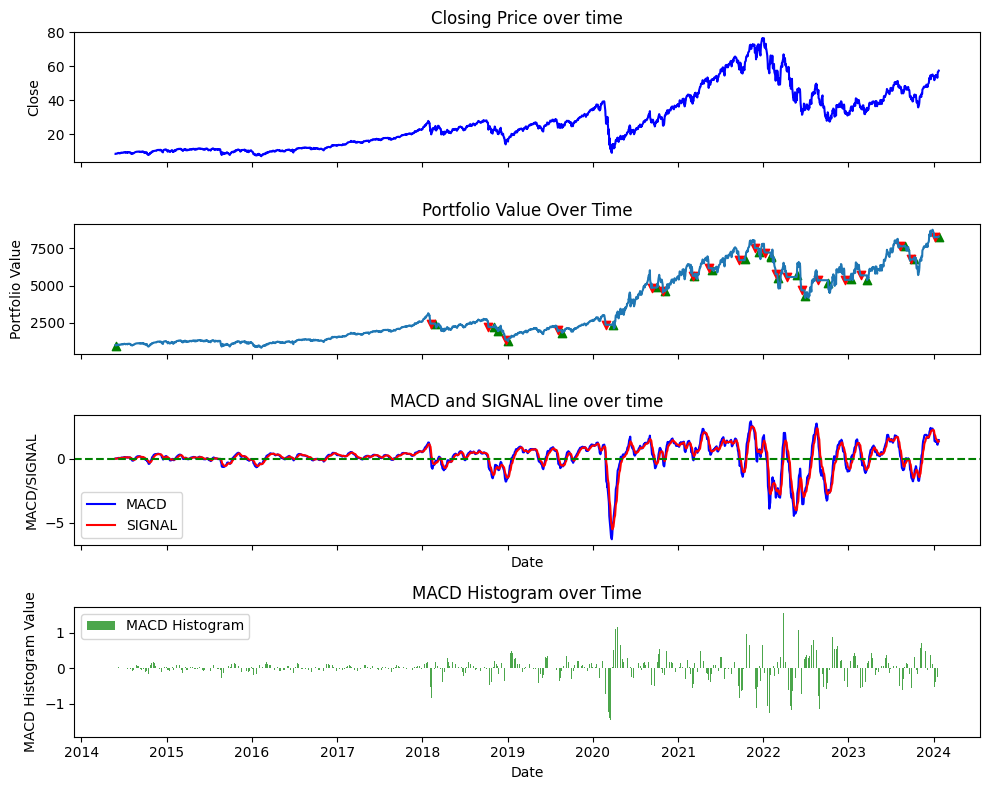

In [98]:
fig, (ax1, ax2, ax5, ax4) = plt.subplots(4, sharex=True, figsize=(10,8))

ax1.plot(daily.index, daily['Close'], label='Close', color='blue')
ax1.set_title('Closing Price over time')
ax1.set_ylabel('Close')

ax2.plot(daily.index, portfolio_values)
ax2.scatter(buy_dates, buy_portfolio_values, color='g', marker='^')  # buy markers
ax2.scatter(sell_dates, sell_portfolio_values, color='r', marker='v')  # sell markers
ax2.set_title('Portfolio Value Over Time')
ax2.set_ylabel('Portfolio Value')

ax4.bar(daily.index, daily['HIST_MACD'], label='MACD Histogram', color='green', alpha=0.7)
ax4.legend(loc='upper left')
ax4.set_title('MACD Histogram over Time')
ax4.set_xlabel('Date')
ax4.set_ylabel('MACD Histogram Value')

# Plot MACD
ax5.plot(daily.index, daily['MACD'], label='MACD', color='blue')
ax5.plot(daily.index, daily['SIGNAL'], label='SIGNAL', color='red')
ax5.set_title('MACD and SIGNAL line over time')
ax5.set_xlabel('Date')
ax5.set_ylabel('MACD/SIGNAL')
ax5.legend()
ax5.axhline(0, color='green', linestyle='--')

plt.tight_layout()
plt.show()

In [99]:
hourly_macd = MACD(hourly, period_fast=6, period_slow=20, signal=10)
hourly['MACD'] = hourly_macd['MACD']
hourly['SIGNAL'] = hourly_macd['SIGNAL']
hourly['HIST_MACD'] = hourly['MACD'] - hourly['SIGNAL']
hourly.dropna(inplace=True)

In [100]:
hourly_cash = 1000
hourly_shares = 0 
hourly_buy_price = 0 
hourly_portfolio_values = []
hourly_buy_dates = []
hourly_sell_dates = []
hourly_buy_portfolio_values = []
hourly_sell_portfolio_values = []

for i in range(1, len(hourly)):
    # Buy at the open price if yesterday's MACD was above the signal line
    if hourly.iloc[i-1]['MACD'] > (hourly.iloc[i-1]['SIGNAL']) and hourly_cash > hourly.iloc[i]['Close']:
        hourly_shares_bought = hourly_cash // hourly.iloc[i]['Close']
        hourly_cash -= hourly_shares_bought * hourly.iloc[i]['Close']
        hourly_shares += hourly_shares_bought
        hourly_buy_price = hourly.iloc[i]['Close']
        hourly_buy_dates.append(hourly.index[i])
        hourly_buy_portfolio_values.append(hourly_cash + hourly_shares * hourly.iloc[i]['Close'])
        

    # Sell at the close price if today's MACD is below the signal line
    elif hourly.iloc[i]['MACD'] < hourly.iloc[i]['SIGNAL'] and hourly_shares > 0:
        hourly_cash += hourly_shares * hourly.iloc[i]['Close']
        hourly_shares = 0
        hourly_sell_dates.append(hourly.index[i])
        hourly_sell_portfolio_values.append(hourly_cash)
    
    hourly_portfolio_value = hourly_cash + hourly_shares * hourly.iloc[i]['Close']
    hourly_portfolio_values.append(hourly_portfolio_value)

# Calculate the final portfolio value
hourly_portfolio_value = hourly_cash + hourly_shares * hourly.iloc[-1]['Close']
hourly = hourly.iloc[1:]

print(f'Final portfolio value: {hourly_portfolio_value}')

hourly_running_max = np.maximum.accumulate(hourly_portfolio_values)
hourly_drawdown = (hourly_running_max - hourly_portfolio_values) / hourly_running_max
hourly_max_drawdown = np.max(hourly_drawdown)

print(f'Maximum Drawdown: {100*hourly_max_drawdown}')


Final portfolio value: 7042.520000000006
Maximum Drawdown: 54.727490125438486


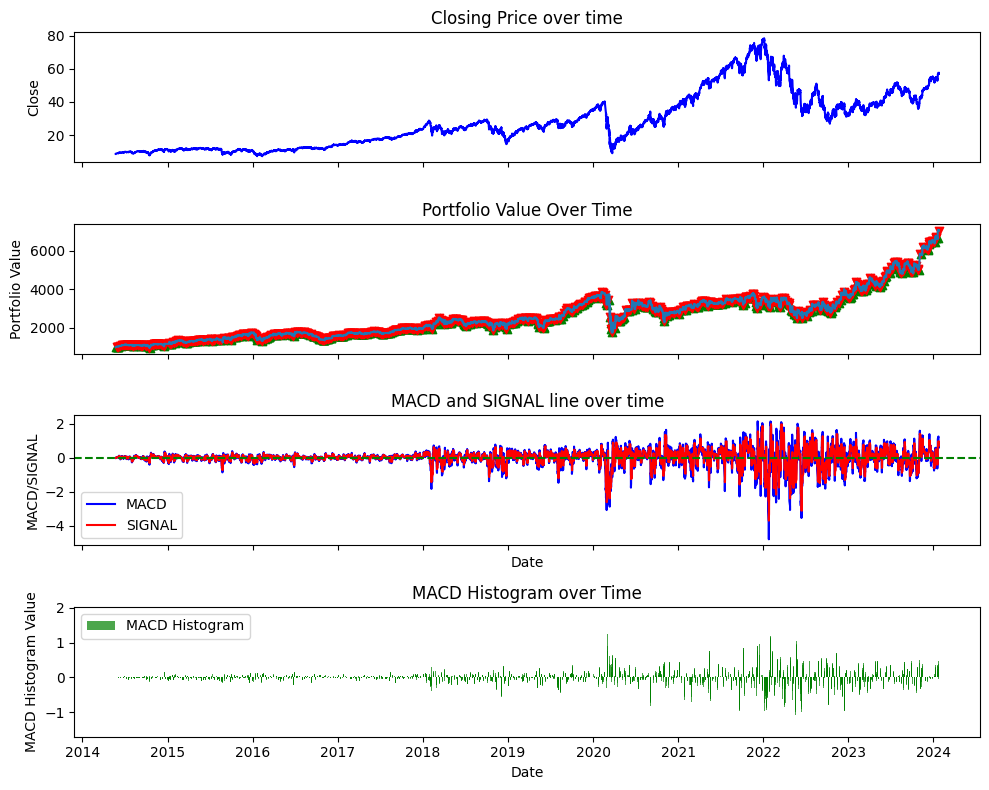

In [101]:
fig, (ax1, ax2, ax5, ax4) = plt.subplots(4, sharex=True, figsize=(10,8))

ax1.plot(hourly.index, hourly['Close'], label='Close', color='blue')
ax1.set_title('Closing Price over time')
ax1.set_ylabel('Close')

ax2.plot(hourly.index, hourly_portfolio_values)
ax2.scatter(hourly_buy_dates, hourly_buy_portfolio_values, color='g', marker='^')  
ax2.scatter(hourly_sell_dates, hourly_sell_portfolio_values, color='r', marker='v') 
ax2.set_title('Portfolio Value Over Time')
ax2.set_ylabel('Portfolio Value')

ax4.bar(hourly.index, hourly['HIST_MACD'], label='MACD Histogram', color='green', alpha=0.7)
ax4.legend(loc='upper left')
ax4.set_title('MACD Histogram over Time')
ax4.set_xlabel('Date')
ax4.set_ylabel('MACD Histogram Value')

ax5.plot(hourly.index, hourly['MACD'], label='MACD', color='blue')
ax5.plot(hourly.index, hourly['SIGNAL'], label='SIGNAL', color='red')
ax5.set_title('MACD and SIGNAL line over time')
ax5.set_xlabel('Date')
ax5.set_ylabel('MACD/SIGNAL')
ax5.legend()
ax5.axhline(0, color='green', linestyle='--')

# Display the figure
plt.tight_layout()
plt.show()


In [102]:
"""
now i will combine the two strategies and see how they perform
next step after this: use NN on weekly, daily, eod hourly to predict buy/sell on next day open
"""

'\nnow i will combine the two strategies and see how they perform\nnext step after this: use NN on weekly, daily, eod hourly to predict buy/sell on next day open\n'

In [103]:
hourly = pd.read_csv('hourlyUPRO14-24.csv')
hourly = hourly.iloc[::-1]
hourly['Date'] = pd.to_datetime(hourly['Date'])
hourly.set_index('Date', inplace=True)
hourly = hourly.rename(columns={'Last Price': 'Close'})

daily = pd.read_csv('dailyUPRO14-24.csv')
daily['Date'] = pd.to_datetime(daily['Date'])
daily.set_index('Date', inplace=True)
daily = daily.drop(columns=['Close'])
daily = daily.rename(columns={'Adj Close': 'Close'})

macd = MACD(daily)
daily['MACD'] = macd['MACD']
daily['SIGNAL'] = macd['SIGNAL']
daily['HIST_MACD'] = daily['MACD'] - daily['SIGNAL']
daily.dropna(inplace=True)

# hourly_macd = MACD(hourly, period_fast=6, period_slow=20, signal=10)
hourly_macd = MACD(hourly)

hourly['MACD_hourly'] = hourly_macd['MACD']
hourly['SIGNAL_hourly'] = hourly_macd['SIGNAL']
hourly['HIST_MACD_hourly'] = hourly['MACD_hourly'] - hourly['SIGNAL_hourly']
hourly.dropna(inplace=True)

In [104]:
eod_hourly = hourly.groupby(hourly.index.date).last()
eod_hourly.head(10)

,Close,Volume,MACD_hourly,SIGNAL_hourly,HIST_MACD_hourly
2014-05-23,8.703,2436588,0.002172,0.001210,0.000962
2014-05-27,8.867,1205244,0.021899,0.014897,0.007002
2014-05-28,8.842,1366692,0.022165,0.021524,0.000641
2014-05-29,8.979,1565148,0.033432,0.026128,0.007304
2014-05-30,9.017,2266824,0.040288,0.036220,0.004069
2014-06-02,9.057,1395804,0.042553,0.040780,0.001773
2014-06-03,9.043,1138548,0.030135,0.034021,-0.003885
2014-06-04,9.087,2177232,0.032686,0.032420,0.000266
2014-06-05,9.275,1438368,0.070536,0.054386,0.016150
2014-06-06,9.407,1283916,0.097768,0.086490,0.011277


In [105]:
hourly.tail(14)

,Close,Volume,MACD_hourly,SIGNAL_hourly,HIST_MACD_hourly
Date,,,,,
2024-01-22 09:30:00,57.370,1189549,0.770620,0.446473,0.324147
2024-01-22 10:30:00,57.260,960070,0.828653,0.522909,0.305744
2024-01-22 11:30:00,57.220,457811,0.861487,0.590624,0.270862
2024-01-22 12:30:00,56.860,465722,0.848675,0.642235,0.206441
2024-01-22 13:30:00,57.110,542584,0.848910,0.683570,0.165340
2024-01-22 14:30:00,57.285,648822,0.853379,0.717531,0.135848
2024-01-22 15:30:00,57.050,2944569,0.828409,0.739707,0.088702
2024-01-23 09:30:00,57.175,755049,0.809377,0.753641,0.055736
2024-01-23 10:30:00,56.890,637848,0.762507,0.755414,0.007093


In [106]:
daily.tail()

,Open,High,Low,Close,Volume,MACD,SIGNAL,HIST_MACD
Date,,,,,,,,
2024-01-17,53.169998,53.490002,52.500000,53.299999,5820300,1.105718,1.398568,-0.292850
2024-01-18,53.830002,54.869999,53.320000,54.680000,7184900,1.086093,1.336073,-0.249981
2024-01-19,55.060001,56.810001,54.830002,56.730000,7720200,1.221872,1.313233,-0.091361
2024-01-22,57.270000,57.680000,56.820000,57.049999,8886200,1.339855,1.318557,0.021297
2024-01-23,57.250000,57.619999,56.840000,57.520000,4286700,1.454515,1.345749,0.108766


In [107]:
# check what date is in daily but not eod_hourly
daily_dates = daily.index.date
eod_hourly_dates = eod_hourly.index
for date in daily_dates:
    if date not in eod_hourly_dates:
        print(date)
# drop 2019-07-23 from daily
daily.drop(index='2019-07-23', inplace=True)
len(daily) == len(eod_hourly)

2019-07-23


True

In [108]:
# daily = daily.tail(500)
# eod_hourly = eod_hourly.tail(500)

In [85]:
# buying and selling EOD

buy_conditions = lambda i: daily.iloc[i]['MACD'] > (daily.iloc[i]['SIGNAL']) or (daily.iloc[i]['MACD'] > (daily.iloc[i]['SIGNAL']-0.5) and eod_hourly.iloc[i]['MACD_hourly'] > (eod_hourly.iloc[i]['SIGNAL_hourly']))
sell_conditions = lambda i: daily.iloc[i]['MACD'] < (daily.iloc[i]['SIGNAL']-0.1)

cash = 1000
shares = 0
buy_price = 0 
portfolio_values = []
buy_dates = []
sell_dates = []
buy_portfolio_values = []
sell_portfolio_values = []
stop_loss_price = 0

for i in range(1, len(daily)):
    # Buy at the close price if current MACD is above the signal line
    if buy_conditions(i) and cash > daily.iloc[i]['Close']:
        shares_bought = cash // daily.iloc[i]['Close']
        cash -= shares_bought * daily.iloc[i]['Close']
        shares += shares_bought
        buy_price = daily.iloc[i]['Close']
        buy_dates.append(daily.index[i])
        buy_portfolio_values.append(cash + shares * daily.iloc[i]['Close'])
        stop_loss_price = daily.iloc[i]['Close']*0.95
        
    
    elif shares > 0 and daily.iloc[i]['Low'] < stop_loss_price:
        cash += shares * stop_loss_price
        shares = 0
        sell_dates.append(daily.index[i])
        sell_portfolio_values.append(cash)

    elif shares > 0 and (sell_conditions(i)):
        cash += shares * daily.iloc[i]['Close']
        shares = 0
        sell_dates.append(daily.index[i])
        sell_portfolio_values.append(cash)
    
    portfolio_value = cash + shares * daily.iloc[i]['Close']
    portfolio_values.append(portfolio_value)



portfolio_value = cash + shares * daily.iloc[-1]['Close']

daily = daily.iloc[1:]
eod_hourly = eod_hourly.iloc[1:]

print(f'Final portfolio value: {portfolio_value}')


running_max = np.maximum.accumulate(portfolio_values)
drawdown = (running_max - portfolio_values) / running_max
max_drawdown = np.max(drawdown)

print(f'Maximum Drawdown: {-100*max_drawdown}')

Final portfolio value: 20106.153666649985
Maximum Drawdown: -34.61266041993003


In [109]:
buy_conditions = lambda i: daily.iloc[i-1]['MACD'] > (daily.iloc[i-1]['SIGNAL']) or (daily.iloc[i-1]['MACD'] > (daily.iloc[i-1]['SIGNAL']-0.5) and eod_hourly.iloc[i]['MACD_hourly'] > (eod_hourly.iloc[i]['SIGNAL_hourly']+0.1))
sell_conditions = lambda i: daily.iloc[i]['MACD'] < (daily.iloc[i]['SIGNAL']-0.5)

psuedo code:
if daily macd > daily signal

In [86]:
cash = 1000
shares = 0
buy_price = 0 
portfolio_values = []
buy_dates = []
sell_dates = []
buy_portfolio_values = []
sell_portfolio_values = []
stop_loss_price = 0

for i in range(1, len(daily)):
    # Buy at the open price if yesterday's MACD was above the signal line
    if buy_conditions(i) and cash > daily.iloc[i]['Open']:
        shares_bought = cash // daily.iloc[i]['Open']
        cash -= shares_bought * daily.iloc[i]['Open']
        shares += shares_bought
        buy_price = daily.iloc[i]['Open']
        buy_dates.append(daily.index[i])
        buy_portfolio_values.append(cash + shares * daily.iloc[i]['Close'])
        stop_loss_price = daily.iloc[i]['Open']*0.95
        
    
    elif shares > 0 and daily.iloc[i]['Low'] < stop_loss_price:
        cash += shares * stop_loss_price
        shares = 0
        sell_dates.append(daily.index[i])
        sell_portfolio_values.append(cash)

    elif shares > 0 and (sell_conditions(i)):
        cash += shares * daily.iloc[i]['Close']
        shares = 0
        sell_dates.append(daily.index[i])
        sell_portfolio_values.append(cash)
    
    portfolio_value = cash + shares * daily.iloc[i]['Close']
    portfolio_values.append(portfolio_value)



# Calculate the final portfolio value
portfolio_value = cash + shares * daily.iloc[-1]['Close']

# drop first row in daily
daily = daily.iloc[1:]
eod_hourly = eod_hourly.iloc[1:]

print(f'Final portfolio value: {portfolio_value}')


running_max = np.maximum.accumulate(portfolio_values)
drawdown = (running_max - portfolio_values) / running_max
max_drawdown = np.max(drawdown)

print(f'Maximum Drawdown: {-100*max_drawdown}')

Final portfolio value: 22036.53069794998
Maximum Drawdown: -39.58858273433042


In [87]:
len(buy_dates), len(sell_dates)

(189, 186)

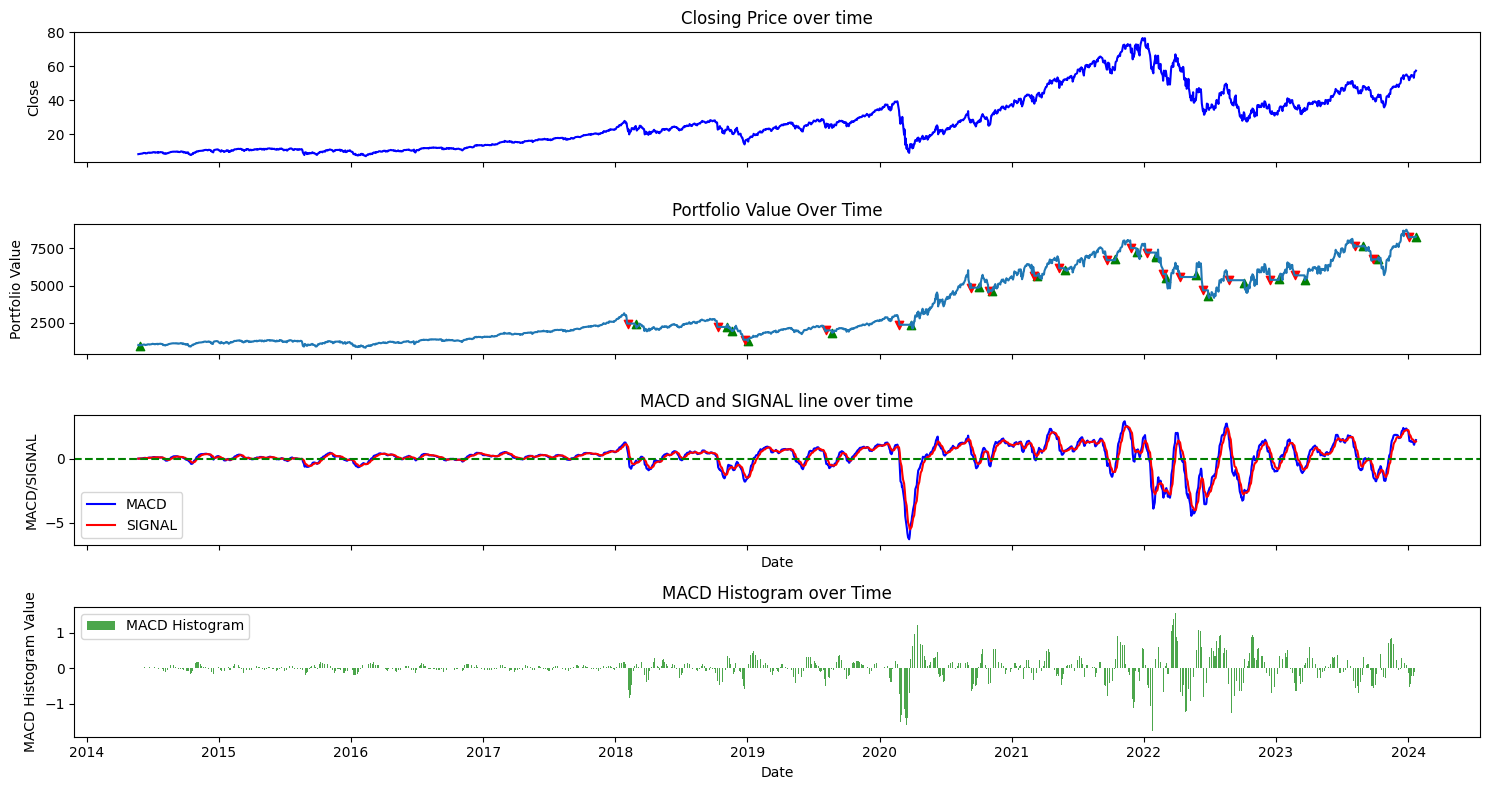

In [110]:
# Create subplots
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True, figsize=(15,8))

# Plot Closing Price
ax1.plot(daily.index, daily['Close'], label='Close', color='blue')
ax1.set_title('Closing Price over time')
ax1.set_ylabel('Close')

ax2.plot(daily.index, portfolio_values)
ax2.scatter(buy_dates, buy_portfolio_values, color='g', marker='^')  # buy markers
ax2.scatter(sell_dates, sell_portfolio_values, color='r', marker='v')  # sell markers
ax2.set_title('Portfolio Value Over Time')
ax2.set_ylabel('Portfolio Value')

# Plot MACD
ax3.plot(daily.index, daily['MACD'], label='MACD', color='blue')
ax3.plot(daily.index, daily['SIGNAL'], label='SIGNAL', color='red')
ax3.set_title('MACD and SIGNAL line over time')
ax3.set_xlabel('Date')
ax3.set_ylabel('MACD/SIGNAL')
ax3.legend()
ax3.axhline(0, color='green', linestyle='--')

ax4.bar(daily.index, daily['HIST_MACD'], label='MACD Histogram', color='green', alpha=0.7)
ax4.legend(loc='upper left')
ax4.set_title('MACD Histogram over Time')
ax4.set_xlabel('Date')
ax4.set_ylabel('MACD Histogram Value')

# Display the figure
plt.tight_layout()
plt.show()